## **Pacotes**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os

## **Pré Processamento dos Dados**

In [72]:
# CARREGANDO OS DADOS
df = pd.read_csv(os.getcwd() + '\\data\\seoul_bike_data.csv', sep = ',', encoding = 'unicode_escape')

# TRADUZINDO O NOME DAS COLUNAS
df.columns = [
    'data',
    'qtde_bicicletas_alugadas',
    'hora',
    'temperatura',
    'umidade',
    'velocidade_do_vento',
    'visibilidade',
    'temperatura_ponto_de_orvalho',
    'radiacao_solar',
    'volume_de_chuva',
    'volume_de_neve',
    'estacao_do_ano',
    'feriado',
    'dia_util'
]

# TRANSFORMANDO OS DADOS DE DATA EM DATETIME
df['data'] = pd.to_datetime(df['data'], format = '%d/%m/%Y')

# CRIANDO UMA COLUNA SÓ COM O MÊS E O ANO
df['ano_e_mes'] = df['data'].apply(lambda data: datetime(year = data.year, month = data.month, day = 1))

# CRIANDO UMA COLUNA COM A DATA INCLUINDO A HORA
df['data_com_hora'] = np.nan
lista_data_com_hora = []
for i in df.index:
    ano = df.loc[i, 'data'].year
    mes = df.loc[i, 'data'].month
    dia = df.loc[i, 'data'].day
    hora = df.loc[i, 'hora']
    lista_data_com_hora.append(datetime(ano, mes, dia, hora))
df['data_com_hora'] = lista_data_com_hora

# CRIANDO UMA COLUNA COM O DIA DA SEMANA
df['dia_da_semana'] = df['data'].apply(lambda data: data.weekday())

# TRANSFORMANDO OS DIAS DA SEMANA DE NÚMERO PARA NOME
dicionario_dia_semana = {
    0: 'segunda',
    1: 'terça',
    2: 'quarta',
    3: 'quinta',
    4: 'sexta',
    5: 'sabado',
    6: 'domingo'
}
df['dia_da_semana'] = df['dia_da_semana'].map(dicionario_dia_semana)

# TRADUZINDO O NOME DAS ESTAÇÕES DO ANO PARA PORTUGUÊS
dicionario_estacao_do_ano = {
    'Summer': 'verao',
    'Spring': 'primavera',
    'Autumn': 'outono',
    'Winter': 'inverno'
}
df['estacao_do_ano'] = df['estacao_do_ano'].map(dicionario_estacao_do_ano)

# TRADUZINDO OS VALORES DA COLUNA FERIADO
df['feriado'] = df['feriado'].apply(lambda feriado: 'sim' if feriado == 'Holiday' else 'nao')

# TRADUZINDO OS VALORES DA COLUNA DIA UTIL
df['dia_util'] = df['dia_util'].apply(lambda dia_util: 'sim' if dia_util == 'Yes' else 'nao')

# CRIANDO UMA LISTA COM AS VARIÁVEIS NUMERICAS E REMOVENDO VARIÁVEIS QUE NÃO SÃO NECESSÁRIAS
variaveis_numericas = df.select_dtypes(include = ['int', 'float']).columns.to_list()
variaveis_numericas = [nome_coluna for nome_coluna in variaveis_numericas if nome_coluna not in ['qtde_bicicletas_alugadas']]

# CRIANDO UMA LISTA COM AS VARIÁVEIS CATEGÓRICAS
variaves_categoricas = df.select_dtypes(include = ['object']).columns.to_list()

## **Criando o Modelo**

In [75]:
class pipeline_modelo_bicicletas:

    def __init__(self, dataframe, nome_target, lista_modelos, lista_transformacoes, lista_variaveis):
        
        # DATAFRAME
        self.df = dataframe

        # NOME DA TARGET
        self.nome_target = nome_target

        # LISTA CONTENDO TUPLAS COM O NOME DO MODELO E O MODELO
        self.lista_modelos = list(zip([str(nome).split('(')[0] for nome in lista_modelos], lista_modelos))

        # LISTA CONTENDO LISTAS, CLASSIFICADAS EM CATEGÓRICAS OU NUMÉRICAS, QUE ARMAZENAM OS NOMES DAS COLUNAS
        self.lista_variaveis = lista_variaveis

        # LISTA CONTENDO TUPLAS COM O NOME DA TRANSFORMAÇÃO, A CLASSE DA TRANSFORMAÇÃO QUE SERÁ APLICADA E A LISTA CONTENDO AS COLUNAS EM QUE ESTA TRANSFORMAÇÃO SERÁ APLICADA
        self.lista_transformacoes = list(zip([str(nome).split('(')[0] for nome in lista_transformacoes], lista_transformacoes, lista_variaveis))

    # FUNÇÃO QUE FAZ O PAPEL DE TREINAR O MODELO
    def treinar(self, estratificar = None, metodo_treino = 'holdout', percentual_teste = 0.3, kfolds = 5, pontuacao = 'r2'):
        
        # DATAFRAME SOMENTE COM AS VARIÁVEIS FEATURE
        X = self.df[list(set([variavel for lista in self.lista_variaveis for variavel in lista]))]

        # SERIES DA VARIÁVEL TARGET
        y = self.df[self.nome_target]

        # INSTÂNCIA UMA CLASSE QUE FUNCIONA COMO UM PIPELINE DE PRÉ PROCESSAMENTO DOS DADOS, UTILIZANDO OS TRANFORMADORES
        transformador = ColumnTransformer(transformers = self.lista_transformacoes, remainder = 'passthrough')

        # SE O MÉTODO DE TREINO FOR HOLDOUT
        if metodo_treino == 'holdout':
            
            # FAZ O HOLDOUT, DIVISÃO DOS DADOS EM TREINO E TESTE
            X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = percentual_teste)

            # ITERAÇÃO PARA TREINAMENTO E VALIDAÇÃO EM CADA MODELO
            for nome_modelo, modelo in self.lista_modelos:
                
                # PIPELINE COM A ARQUITETURA DE PROCESSAMENTO DOS DADOS E DO MODELO
                pipeline = Pipeline(
                    steps = [
                        ('pre_processamento', transformador),
                        ('modelo', modelo)
                    ])

                # AJUSTANDO O MODELO COM OS DADOS DE TREINO
                pipeline.fit(X_treino, y_treino)

                # FAZENDO AS PREVISÕES COM OS DADOS DE TESTE
                previsoes = pipeline.predict(X_teste)

                # MÉTRICAS DE AVALIAÇÃO DO MODELO
                print(f'\nModelo: {nome_modelo}\nR2: {r2_score(y_teste, previsoes):.4f}\nMSE: {mean_squared_error(y_teste, previsoes):.2f}\nMAE: {mean_absolute_error(y_teste, previsoes):.2f}')

                # CRIANDO UM GRÁFICO PARA VISUALIZAR OS DADOS DE PREVISÃO E TESTE
                df_previsao = pd.DataFrame({
                    'data_com_hora' : self.df.iloc[y_teste.index]['data_com_hora'],
                    'y_teste': y_teste,
                    'previsoes' : previsoes
                })
                df_previsao = df_previsao.sort_values('data_com_hora')
                tamanho_serie = 60
                plt.figure(figsize = (12,4))
                plt.title(f'Previsão x Teste utilizando {nome_modelo}')
                plt.xlabel('Data e Hora')
                plt.ylabel('Quantidade de Bicicletas Alugadas')
                plt.grid(True, alpha = 0.2)
                plt.plot(df_previsao['data_com_hora'][:tamanho_serie], df_previsao['y_teste'][:tamanho_serie], color = 'red', label = 'Teste')
                plt.plot(df_previsao['data_com_hora'][:tamanho_serie], df_previsao['previsoes'][:tamanho_serie], color = 'grey', label = 'Previsão')
                plt.legend()
                plt.show()

        # SE O MÉTODO DE TREINO FOR VALIDAÇÃO CRUZADA
        elif metodo_treino == 'validacao_cruzada':

            # ITERAÇÃO PARA TREINAMENTO E VALIDAÇÃO EM CADA MODELO
            for nome_modelo, modelo in self.lista_modelos:

                # PIPELINE COM A ARQUITETURA DE PROCESSAMENTO DOS DADOS E DO MODELO
                pipeline = Pipeline(
                    steps = [
                        ('pre_processamento', transformador),
                        ('modelo', modelo)
                    ])

                # REALIZANDO UMA VALIDAÇÃO CRUZADA UTILIZANDO O PIPELINE
                pontuacao_validacao_cruzada = cross_val_score(pipeline, X, y, cv = kfolds, scoring = pontuacao)

                # MÉTRICAS DE AVALIAÇÃO
                print(f'\nModelo: {nome_modelo}\nMétrica: {pontuacao}\nKfolds: {kfolds}\nValores em cada fold: {[float(round(valor, 2)) for valor in pontuacao_validacao_cruzada]}\nMédia de {pontuacao}: {pontuacao_validacao_cruzada.mean():.4f}')

        # SE O MÉTODO DE TREINO NÃO FOR VÁLIDO
        else:
            print("O método de treinamento não é valido. Não é 'validacao_cruzada' ou 'holdout'.")


Modelo: RandomForestRegressor
R2: 0.9121
MSE: 37307.58
MAE: 113.58


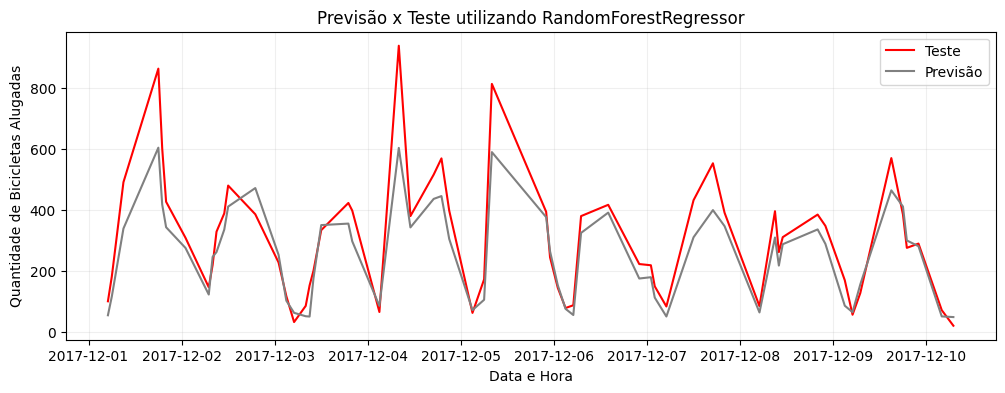


Modelo: LinearRegression
R2: 0.5427
MSE: 194085.40
MAE: 329.82


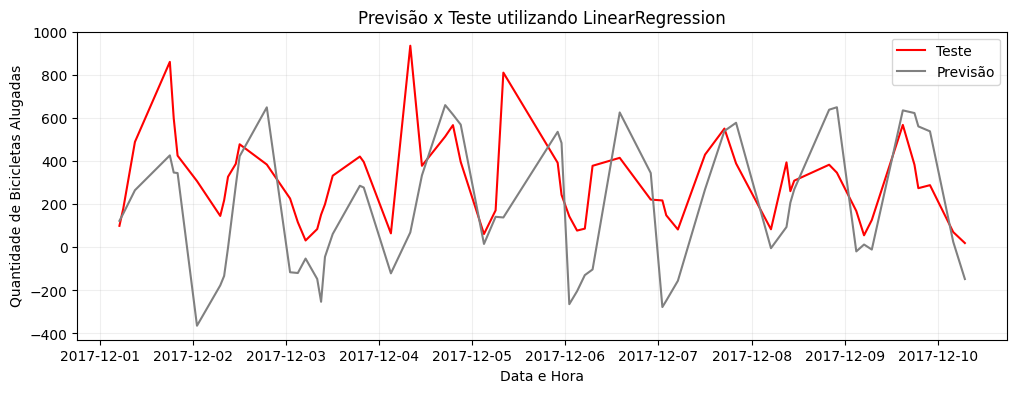

In [76]:
# LISTA COM OS MODELOS DE TREINO
lista_modelos = [RandomForestRegressor(), LinearRegression()]

# LISTA COM AS LISTAS DE TIPOS DE VARIÁVEIS
lista_variaveis = [variaveis_numericas, variaves_categoricas]

# LISTA COM AS TRANSFORMAÇÕES (OBS: A POSIÇÃO DA TRANSFORMAÇÃO NA LISTA TEM QUE ESTAR NA ORDEM DE ACORDO COM A ORDEM EM 'lista_variaveis')
lista_transformacoes = [StandardScaler(), OneHotEncoder(sparse_output = False)]

# INSTÂNCIA DO PIPELINE CRIADO UTILIZANDO OS DADOS DE BICICLETAS
pipeline = pipeline_modelo_bicicletas(dataframe = df,
                                      nome_target = 'qtde_bicicletas_alugadas',
                                      lista_modelos = lista_modelos,
                                      lista_transformacoes = lista_transformacoes,
                                      lista_variaveis = lista_variaveis)

# TREINA E AVALIA CADA MODELO UTILIZANDO HOLDOUT COM 30% PARA TESTE E 70% PARA TREINO
pipeline.treinar(metodo_treino = 'holdout', percentual_teste = 0.3)

O modelo *RandomForestRegressor* apresentou ótimos resultados de previsão, alcançando uma $\small R^2$ de mais de 0.90 e errando, em média, em relação à quantidade exata de bicicletas alugadas em aproximadamente 114 bicicletas.

Já o modelo *LinearRegression* não teve a mesma performance, alcançando uma $\small R^2$ de aproximadamente 0.54 e errando, em média, em relação à quantidade exata de bicicletas alugadas em aproximadamente 330 bicicletas. Foi identificado que o modelo *LinearRegression* também comete o erro de fazer previsões abaixo de zero.

Embora o primeiro modelo já esteja ótimo, podemos testar outras configurações no pipeline para verificar se ele pode ser melhorado, como utilizar a transformação *MinMaxScaler* ao invés da *StandardScaler*.


Modelo: RandomForestRegressor
R2: 0.9143
MSE: 35447.69
MAE: 112.48


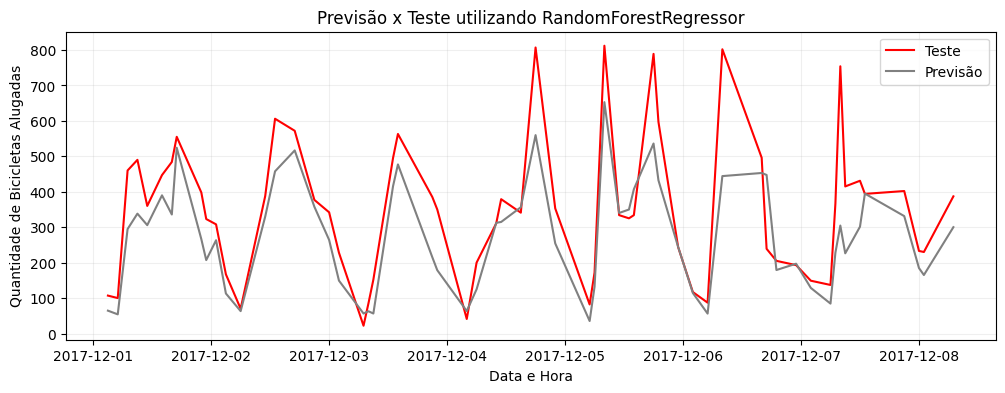


Modelo: LinearRegression
R2: 0.5470
MSE: 187422.91
MAE: 328.38


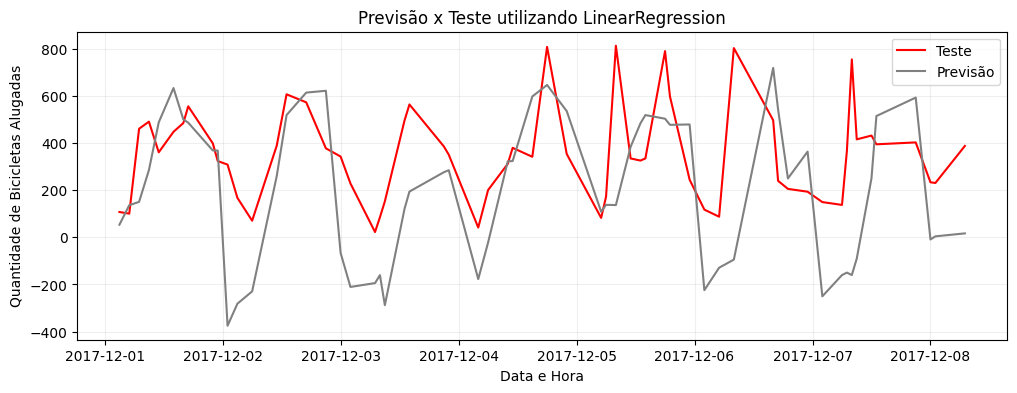

In [77]:
# LISTA COM OS MODELOS DE TREINO
lista_modelos = [RandomForestRegressor(), LinearRegression()]

# LISTA COM AS LISTAS DE TIPOS DE VARIÁVEIS
lista_variaveis = [variaveis_numericas, variaves_categoricas]

# LISTA COM AS TRANSFORMAÇÕES (OBS: A POSIÇÃO DA TRANSFORMAÇÃO NA LISTA TEM QUE ESTAR NA ORDEM DE ACORDO COM A ORDEM EM 'lista_variaveis')
lista_transformacoes = [MinMaxScaler(), OneHotEncoder(sparse_output = False)]

# INSTÂNCIA DO PIPELINE CRIADO UTILIZANDO OS DADOS DE BICICLETAS
pipeline = pipeline_modelo_bicicletas(dataframe = df,
                                      nome_target = 'qtde_bicicletas_alugadas',
                                      lista_modelos = lista_modelos,
                                      lista_transformacoes = lista_transformacoes,
                                      lista_variaveis = lista_variaveis)

# TREINA E AVALIA CADA MODELO UTILIZANDO HOLDOUT COM 30% PARA TESTE E 70% PARA TREINO
pipeline.treinar(metodo_treino = 'holdout', percentual_teste = 0.3)

Testando algumas vezes, praticamente não foi identificada uma mudança significativa nas métricas de avaliação.

Podemos testar uma modelagem com base em redes neurais através do pacote `torch`, do framework PyTorch, para verificar se conseguimos resultados ainda melhores do que o *RandomForestRegressor* do `scikit-learn`.

## **Criando a Rede Neural**

In [78]:
# ORGANIZANDO OS DADOS EM UMA CLASSE PADRÃO DATASET PARA INTEGRAÇÃO COM O DATALOADER
class bicicletas_dataset(Dataset):
    
    def __init__(self, X, y, variaveis_numericas, variaves_categoricas):
        transformador = ColumnTransformer(
            transformers = [
                ('num_standard_scaler', StandardScaler(), variaveis_numericas),
                ('cat_one_hot_encoder', OneHotEncoder(sparse_output = False), variaves_categoricas)
            ],
            remainder = 'passthrough'
        )
        self.X = torch.tensor(transformador.fit_transform(X), dtype = torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype = torch.float32)

    # RETORNA A QUANTIDADE DE LINHAS DO DATAFRAME
    def __len__(self):
        return len(self.X)
    
    # RETORNA UMA TUPLA COM TENSORES DOS VALORES DAS FEATURES E DA TARGET
    def __getitem__(self, indice):
        return self.X[indice], self.y[indice]

# HIPERPARÂMETROS
hiperparametros = {
    'tamanho_teste' : 0.3,
    'tamanho_lote' : 32,
    'taxa_de_aprendizado' : 0.001,
    'numero_de_epocas' : 100
}

# DADOS DAS BICICLETAS
X = df[variaveis_numericas + variaves_categoricas]
y = df['qtde_bicicletas_alugadas']

# FAZENDO O HOLDOUT ESTRATIFICANDO PELA ESTAÇÃO DO ANO
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = hiperparametros['tamanho_teste'], stratify = X['estacao_do_ano'])

# CRIANDO UMA INSTÂNCIA DA CLASSE PERSONALIZADA PARA O TREINO E O TESTE
dataset_treino = bicicletas_dataset(X = X_treino, y = y_treino, variaveis_numericas = variaveis_numericas, variaves_categoricas = variaves_categoricas)
dataset_teste = bicicletas_dataset(X = X_teste, y = y_teste, variaveis_numericas = variaveis_numericas, variaves_categoricas = variaves_categoricas)

# CRIANDO O DATALOADER PARA O TREINO E O TESTE
dataloader_treino = DataLoader(dataset_treino, batch_size = hiperparametros['tamanho_lote'], shuffle = True)
dataloader_teste = DataLoader(dataset_teste, batch_size = hiperparametros['tamanho_lote'], shuffle = True)


Época: 1
Custo no Treino: 474.37
Custo no Teste: 290.22

Época: 10
Custo no Treino: 203.28
Custo no Teste: 198.07

Época: 20
Custo no Treino: 175.42
Custo no Teste: 178.71

Época: 30
Custo no Treino: 150.89
Custo no Teste: 176.46

Época: 40
Custo no Treino: 130.85
Custo no Teste: 141.35

Época: 50
Custo no Treino: 117.22
Custo no Teste: 139.87

Época: 60
Custo no Treino: 111.10
Custo no Teste: 128.85

Época: 70
Custo no Treino: 104.90
Custo no Teste: 128.93

Época: 80
Custo no Treino: 98.39
Custo no Teste: 119.54

Época: 90
Custo no Treino: 95.22
Custo no Teste: 135.61

Época: 100
Custo no Treino: 91.11
Custo no Teste: 134.70


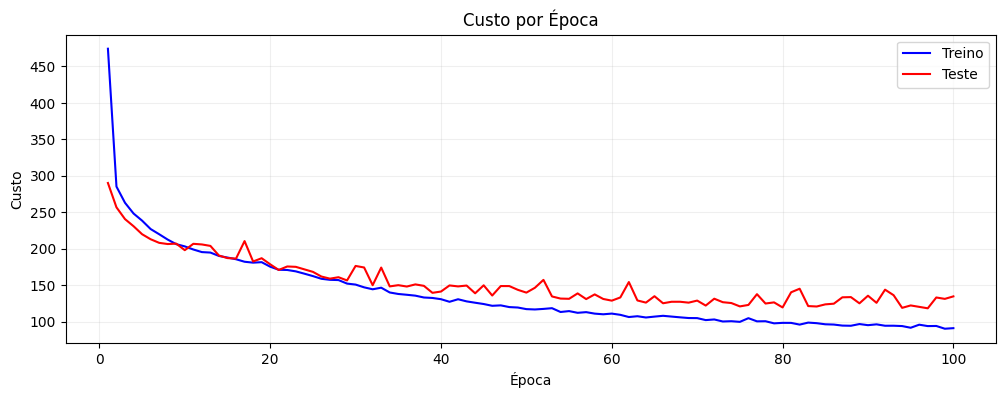

In [79]:
# MODELO
class modelo_bicicleta(nn.Module):

    def __init__(self, tamanho_da_entrada):
        super(modelo_bicicleta, self).__init__()
        
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_da_entrada, tamanho_da_entrada*3),
            nn.ReLU(),
            nn.Linear(tamanho_da_entrada*3, tamanho_da_entrada*4),
            nn.ReLU(),
            nn.Linear(tamanho_da_entrada*4, tamanho_da_entrada*3),
            nn.ReLU(),
            nn.Linear(tamanho_da_entrada*3, tamanho_da_entrada*2),
            nn.ReLU(),
            nn.Linear(tamanho_da_entrada*2, tamanho_da_entrada),
            nn.ReLU(),
            nn.Linear(tamanho_da_entrada, 1)
        )

    def forward(self, X):
        return self.modelo(X)

# FUNÇÃO PARA TREINAR O MODELO
def treinar_modelo(modelo, dataloader, funcao_de_custo, otimizador):
    modelo.train()
    custo_total = 0
    for X_lote, y_lote in dataloader:
        otimizador.zero_grad()
        previsao = modelo(X_lote)
        custo = funcao_de_custo(previsao, y_lote.unsqueeze(1))
        custo.backward()
        otimizador.step()
        custo_total += custo.item()
    return custo_total/len(dataloader)

# FUNÇÃO PARA AVALIAR O MODELO
def avaliar_modelo(modelo, dataloader, funcao_de_custo):
    modelo.eval()
    custo_total = 0
    with torch.no_grad():
        for X_lote, y_lote in dataloader:
            previsao = modelo(X_lote)
            custo = funcao_de_custo(previsao, y_lote.unsqueeze(1))
            custo_total += custo.item()
    return custo_total/len(dataloader)

# CRIANDO UMA INSTÂNCIA DO MODELO
hiperparametros['tamanho_da_entrada'] = dataset_treino[0][0].__len__()
modelo_bicicletas = modelo_bicicleta(tamanho_da_entrada = hiperparametros['tamanho_da_entrada'])

# CRIANDO UMA INSTÂNCIA DO OTIMIZADOR
otimizador = optim.Adam(modelo_bicicletas.parameters(), lr = hiperparametros['taxa_de_aprendizado'])

# CRIANDO UMA INSTÂNCIA DA FUNÇÃO DE CUSTO
funcao_de_custo = nn.L1Loss()

# LISTAS PARA AUXILIAR O TREINO E AVALIAÇÃO
lista_custo_treino, lista_custo_teste = [], []
lista_epocas = [n for n in range(1, hiperparametros['numero_de_epocas'] + 1)]

# FOR LOOP DE TREINO E AVALIAÇÃO
for epoca in lista_epocas:
    custo_treino = treinar_modelo(modelo_bicicletas, dataloader_treino, funcao_de_custo, otimizador)
    custo_teste = avaliar_modelo(modelo_bicicletas, dataloader_teste, funcao_de_custo)
    lista_custo_treino.append(custo_treino)
    lista_custo_teste.append(custo_teste)
    if epoca % 10 == 0 or epoca == 1:
        print(f'\nÉpoca: {epoca}\nCusto no Treino: {custo_treino:.2f}\nCusto no Teste: {custo_teste:.2f}')

# CRIANDO UMA GRÁFICO PARA ANALISAR A CURVA DE CUSTO AO LONGO DAS ÉPOCAS
plt.figure(figsize = (12, 4))
plt.title('Custo por Época')
plt.grid(True, alpha = 0.2)
plt.plot(lista_epocas, lista_custo_treino, label = 'Treino', color = 'blue')
plt.plot(lista_epocas, lista_custo_teste, label = 'Teste', color = 'red')
plt.xlabel('Época')
plt.ylabel('Custo')
plt.legend()
plt.show()

A rede apresentou um bom treinamento dado que os custos por época do treino e do teste foram diminuindo ao longo das épocas. Pelo fato de termos utilizado uma função de custo L1, que se baseia no erro médio absoluto, é possível que o MAE total na base de teste completa seja aproximadamente o valor visualizado na centésima época.

Podemos verificar isto e também outras métricas de avaliação. Faremos também um gráfico da previsão x teste tal como visto na modelagem com `scikit-learn`.

Modelo: Rede Neural
R2: 0.8820
MSE: 48127.28
MAE: 130.62


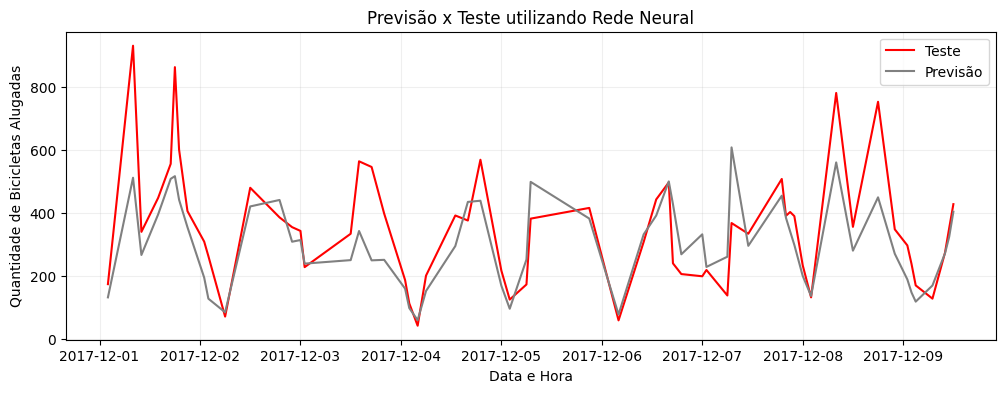

In [80]:
# CALCULANDO MÉTRICAS DE AVALIAÇÃO E FAZENDO UM GRÁFICO PARA VISUALIZAR
modelo_bicicletas.eval()
tamanho_serie = 60
with torch.no_grad():
    for X_lote, y_lote in DataLoader(dataset_teste, batch_size = dataset_teste.__len__()):
        previsao = modelo_bicicletas(X_lote)
        print(f'Modelo: Rede Neural\nR2: {r2_score(y_lote, previsao):.4f}\nMSE: {mean_squared_error(y_lote, previsao):.2f}\nMAE: {mean_absolute_error(y_lote, previsao):.2f}')
    df_previsao = pd.DataFrame({
        'data_com_hora' : df.iloc[y_teste.index]['data_com_hora'],
        'teste' : y_teste,
        'previsao' : previsao.squeeze(1).numpy()
    })
    df_previsao = df_previsao.sort_values('data_com_hora')
    plt.figure(figsize = (12, 4))
    plt.title('Previsão x Teste utilizando Rede Neural')
    plt.xlabel('Data e Hora')
    plt.ylabel('Quantidade de Bicicletas Alugadas')
    plt.grid(True, alpha = 0.2)
    plt.plot(df_previsao['data_com_hora'][:tamanho_serie], df_previsao['teste'][:tamanho_serie], color = 'red', label = 'Teste')
    plt.plot(df_previsao['data_com_hora'][:tamanho_serie], df_previsao['previsao'][:tamanho_serie], color = 'grey', label = 'Previsão')
    plt.legend()
    plt.show()